# 24th September - Motor Pot/Prep Networks - Single Reaches

This notebook trains networks on single reach tasks, then studies how aligned the preparatory and potent subspaces are. 

The data is constructed to contain all combinations of the following parameters.
1. Prep_periods, how long before the first movement is the cue provided.
4. Num_reaches says how many different reaches to have, one-hot coded

In [66]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap, value_and_grad, grad, jit, random
import jax.nn as jnn
from mpl_toolkits.mplot3d import Axes3D
import math
import optax
import scipy
import jax

def get_PCs(vecs, num_eigs = 2):
    vecs = vecs - np.mean(vecs, axis = 1)[:,None]
    covar = vecs@vecs.T
    eigvals, eigvecs = np.linalg.eig(covar)
    
    ordering = np.argsort(eigvals)[::-1]
    #print(f"Propotion of Activity Kept: {np.sum(eigvals[ordering[:2]])/np.sum(eigvals)}")
    return np.real(eigvecs[:,ordering[:num_eigs]]), np.real(eigvals[ordering[:num_eigs]])

def plot_var(vecs, PCs):
    demeaned_act = vecs - np.mean(vecs, axis = 1)[:,None]
    total_var = np.sum(np.power(demeaned_act, 2))
    PC_var = np.sum(np.power(PCs.T@demeaned_act, 2), axis = 1)/total_var
    plt.plot(PC_var)
    return np.sum(PC_var)

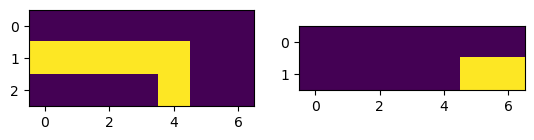

In [178]:
prep_periods = [1, 3, 5]
num_reaches = 2
action_len = 2
T = max(prep_periods) + action_len
num_trials = num_reaches*len(prep_periods)

def generate_data():    
    outputs = jnp.zeros([num_reaches,num_trials,T])
    inputs = jnp.zeros([num_reaches+1,num_trials,T])
    for prep_ind, prep_period in enumerate(prep_periods):
        for reach in range(num_reaches):
            trial_ind = num_reaches*prep_ind + reach
            outputs = outputs.at[reach,trial_ind,prep_period:prep_period+action_len].set(1)
            inputs = inputs.at[reach,trial_ind,:prep_period].set(1)
            inputs = inputs.at[num_reaches,trial_ind,prep_period-1].set(1)
    return inputs, outputs

inputs, outputs = generate_data()

plot_trial = 100
plt.subplot(1,2,1)
plt.imshow(inputs[:,plot_trial,:])

plt.subplot(1,2,2)
plt.imshow(outputs[:,plot_trial,:])

In [179]:
# Define initialising functions, and losses
N = 10 # Number of neurons
I_Size = num_reaches+1
O_Size = num_reaches

# Initialise W orthogonal, and others random
def initialise_weights(N, random_seed, init_scale = 0.01):
    W = jnp.zeros([N, N+1])
    key = random.PRNGKey(random_seed)

    W = W.at[:,-1].set(random.normal(key, (N,))*init_scale)
    Wp = random.normal(key, (N,N))
    Wp, S, V = jnp.linalg.svd(Wp)
    W = W.at[:,:N].set(Wp)

    R = random.normal(key, (O_Size, N+1))*init_scale
    I = random.normal(key, (N, I_Size+1))*init_scale
    params = {'W':W, 'R':R, 'I':I}
    
    return params

@jit
def generate_rep(params, inputs, random_seed):
    # Neurons by time points by trials
    g = jnp.zeros([N, T, num_trials])
    g = g.at[:,0,:].set(jnn.relu(params['I'][:,:-1]@inputs[:,:,0] + params['I'][:,-1][:,None]))

    # For rest we just recurrently go around.
    key = random.PRNGKey(random_seed)
    subkey, key = random.split(key)
    for t in range(1,T):
        input_current = params['W'][:,:-1]@g[:,t-1,:] + params['W'][:,-1][:,None] +params['I'][:,:-1]@inputs[:,:,t] + params['I'][:,-1][:,None] 
        g = g.at[:,t,:].set(jnn.relu(input_current))
    return g

@jit
def loss_weight(W):
    return jnp.sum(jnp.power(W[:,:-1], 2))

@jit
def loss_act(g):
    return jnp.mean(jnp.sum(jnp.power(g, 2), 0))

@jit
def loss_fit(g, R, outputs):
    preds = jnp.einsum('ij, jkl -> ilk', R[:,:-1], g) + R[:,-1][:,None,None]
    return jnp.mean(jnp.sum(jnp.power(outputs - preds, 2), 0))

@jit
def generate_pred(params, g):
    preds = jnp.einsum('ij, jkl -> ilk', params['R'][:,:-1], g) + params['R'][:,-1][:,None,None]
    return preds

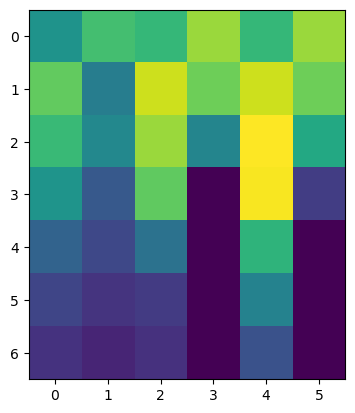

In [180]:
params = initialise_weights(N, random_seed)
g = generate_rep(params, inputs, random_seed)

plt.imshow(g[6,:,:])

In [217]:
mu_fit = 10000
mu_G = 1
mu_W = 1
fit_thresh = 0

@jit
def loss(params, inputs, outputs, random_seed):
    g = generate_rep(params, inputs, random_seed)
    
    fitting_loss = loss_fit(g, params['R'], outputs)  

    weight_loss = loss_weight(params['W'])
    weight_loss += loss_weight(params['R'])
    weight_loss += loss_weight(params['I'])
    
    return mu_fit*jnn.relu(fitting_loss-fit_thresh) + mu_G*loss_act(g) + mu_W*weight_loss

@jit
def update(params, inputs, outputs, opt_state, random_seed):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, inputs, outputs, random_seed)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, value

N = 10
random_seed = 321
learning_rate = 1e-5 #2e-5
scale = 0.1
key = random.PRNGKey(random_seed)
noise_scale = 1

re_init = False
if re_init:
    optimizer = optax.adam(learning_rate)
    params = initialise_weights(N, random_seed, init_scale = scale)
    opt_state = optimizer.init(params)
    min_loss = np.infty
else:
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
print(loss(params, inputs, outputs, random_seed))
min_loss = np.infty


8.307712


In [218]:
num_timesteps = 10000000
print_iter = 10000
noise_scale = 0

for step in range(num_timesteps):
    params, opt_state, loss_val = update(params,  inputs, outputs, opt_state, random_seed)


    if step % print_iter == 0:
        g = generate_rep(params, inputs, random_seed)
            
        fitting_loss = loss_fit(g, params['R'], outputs)  
    
        weight_loss_W = loss_weight(params['W'])
        weight_loss_R = loss_weight(params['R'])
        weight_loss_I = loss_weight(params['I'])

        L_a = loss_act(g)

        loss_comp = mu_fit*jnn.relu(fitting_loss-fit_thresh) + mu_G*L_a + mu_W*(weight_loss_R + weight_loss_I + weight_loss_W)
        print(f"Step {step}, Loss: {loss_val:.5f}, Fit: {fitting_loss:.5f}, Act: {L_a:.5f}, Wei: {weight_loss_W:.5f}, R: {weight_loss_R:.5f}, I: {weight_loss_I:.5f}")

        min_this_step = 0

    if loss_val < min_loss:
        params_best = params
        min_loss = loss_val
        if min_this_step == 0:
            print(f'New min! {loss_val}')
            min_this_step = 1
            

Step 0, Loss: 8.30771, Fit: 0.00000, Act: 0.71241, Wei: 3.36920, R: 2.46610, I: 1.75362
New min! 8.307711601257324
Step 10000, Loss: 8.30770, Fit: 0.00000, Act: 0.71246, Wei: 3.36923, R: 2.46608, I: 1.75363
Step 20000, Loss: 8.30771, Fit: 0.00000, Act: 0.71246, Wei: 3.36925, R: 2.46609, I: 1.75364
Step 30000, Loss: 8.30771, Fit: 0.00000, Act: 0.71246, Wei: 3.36925, R: 2.46609, I: 1.75364
Step 40000, Loss: 8.30771, Fit: 0.00000, Act: 0.71245, Wei: 3.36927, R: 2.46611, I: 1.75365
Step 50000, Loss: 8.30771, Fit: 0.00000, Act: 0.71246, Wei: 3.36927, R: 2.46610, I: 1.75365
Step 60000, Loss: 8.30771, Fit: 0.00000, Act: 0.71246, Wei: 3.36925, R: 2.46608, I: 1.75366
Step 70000, Loss: 8.30771, Fit: 0.00000, Act: 0.71246, Wei: 3.36927, R: 2.46611, I: 1.75367
Step 80000, Loss: 8.30771, Fit: 0.00000, Act: 0.71245, Wei: 3.36928, R: 2.46613, I: 1.75367
Step 90000, Loss: 8.30771, Fit: 0.00000, Act: 0.71246, Wei: 3.36923, R: 2.46609, I: 1.75367
Step 100000, Loss: 8.30771, Fit: 0.00000, Act: 0.71245, W

KeyboardInterrupt: 

In [219]:
print(min_loss)

8.307696


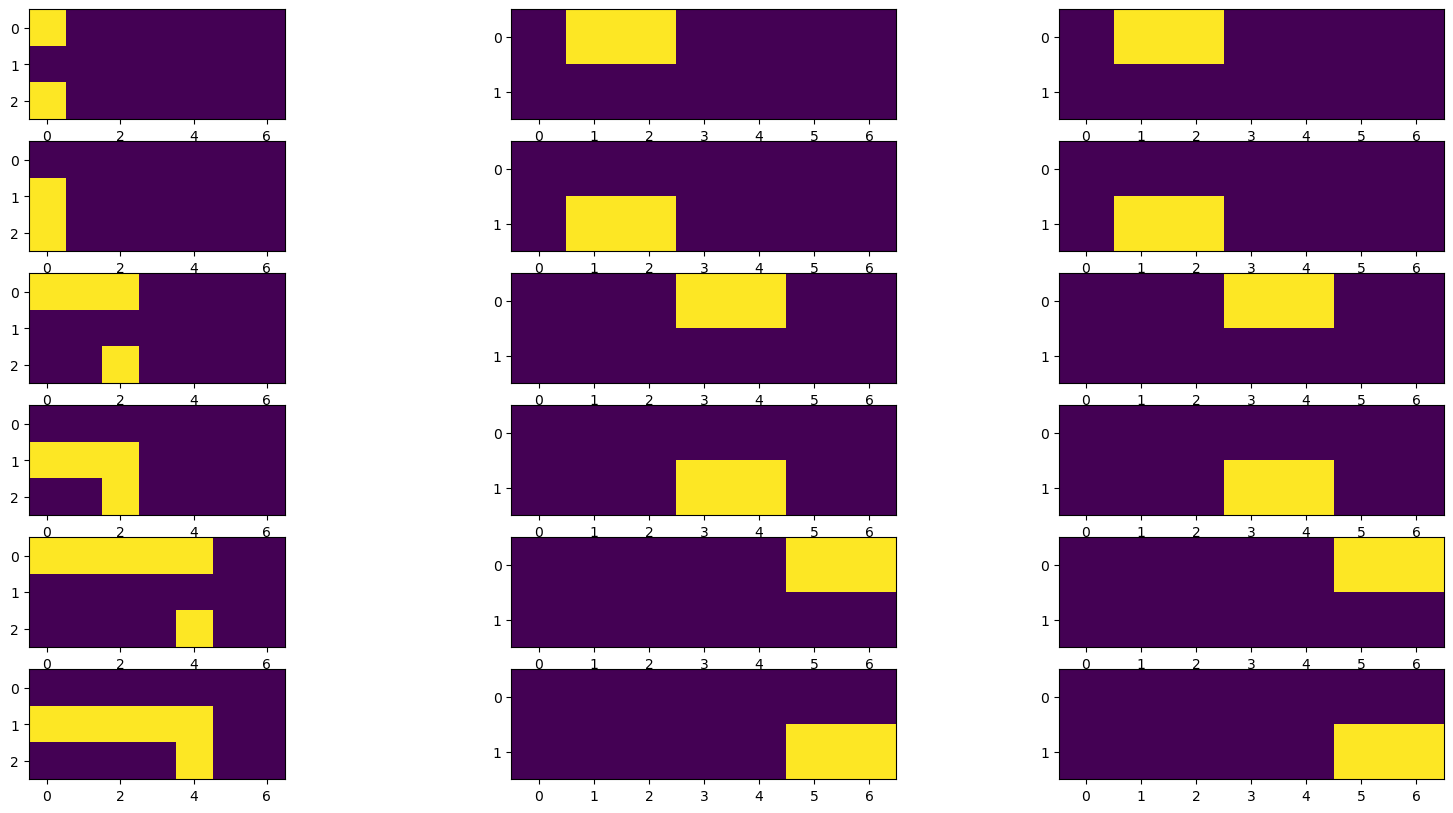

In [220]:
g = generate_rep(params_best, inputs, random_seed)
preds = generate_pred(params_best, g)

plt.figure(figsize = (20, 10))
for ang in range(num_trials):
    plt.subplot(num_trials, 3, ang*3 + 1)
    plt.imshow(inputs[:,ang,:])
    
    plt.subplot(num_trials, 3, ang*3 +2)
    plt.imshow(outputs[:,ang,:])

    plt.subplot(num_trials, 3, ang*3 + 3)
    plt.imshow(preds[:,ang,:])

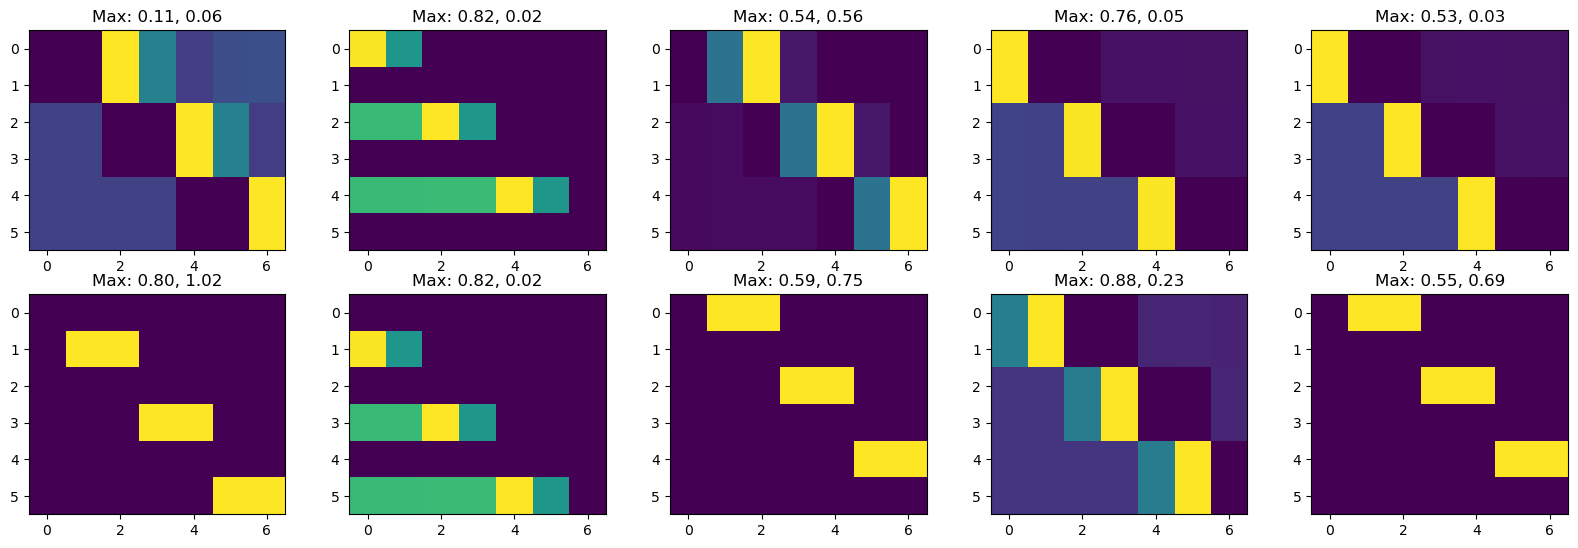

In [221]:
r_norm = np.linalg.norm(params_best['R'], axis = 0)
plt.figure(figsize = (20,20))
for neuron in range(N):
    plt.subplot(6,5, neuron+1)
    plt.imshow(g[neuron,:,:].T)
    plt.title(f'Max: {np.max(g[neuron,:,:]):.2f}, {r_norm[neuron]:.2f}')

Pot in Prep: 0.12413638830184937
Prep in Pot: 0.6494183540344238


Text(0.5, 1.0, 'Pot Act')

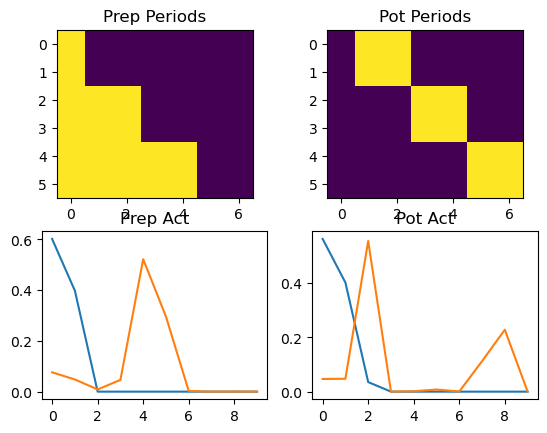

In [235]:
# Now Extract Movement PCs and Prep PCs, and see how much overlap there is
prep_period_times = np.logical_and(np.any(np.abs(inputs) > 0.01, axis = 0), np.all(np.abs(outputs)<0.01 , axis = 0))
pot_period_times = np.logical_or(np.logical_and(np.all(np.abs(inputs) < 0.01,axis=0), np.any(np.abs(outputs)>0.01, axis = 0)), np.logical_and(np.all(np.abs(inputs) < 0.01,axis=0), np.all(np.abs(outputs)<0.01, axis = 0)))
pot_period_times = np.logical_and(np.all(np.abs(inputs) < 0.01,axis=0), np.any(np.abs(outputs)>0.01, axis = 0))

plt.subplot(2,2,1)
plt.imshow(prep_period_times)
plt.title('Prep Periods')

plt.subplot(2,2,2)
plt.imshow(pot_period_times)
plt.title('Pot Periods')

prep_act = g[:,prep_period_times.T]
prep_act = np.reshape(prep_act, [N, int(prep_act.size/N)])
pot_act = g[:,pot_period_times.T]
pot_act = np.reshape(pot_act, [N, int(pot_act.size/N)])

prep_PCs, prep_PC_vals = get_PCs(prep_act, num_eigs = N)
pot_PCs, pot_PC_vals = get_PCs(pot_act, num_eigs = N)

plt.subplot(2,2,3)
prep_in_prep_var = plot_var(prep_act, prep_PCs)
pot_in_prep_var = plot_var(pot_act, prep_PCs)

thresh_var = 0.001

plt.title('Prep Act')
print(f'Pot in Prep: {np.sum(pot_in_prep_var[prep_in_prep_var > thresh_var])}')

plt.subplot(2,2,4)
pot_in_pot_var = plot_var(pot_act, pot_PCs)
prep_in_pot_var = plot_var(prep_act, pot_PCs)
print(f'Prep in Pot: {np.sum(prep_in_pot_var[pot_in_pot_var > thresh_var])}')

plt.title('Pot Act')


0.12413639

In [223]:
def plot_var(vecs, PCs):
    demeaned_act = vecs - np.mean(vecs, axis = 1)[:,None]
    total_var = np.sum(np.power(demeaned_act, 2))
    PC_var = np.sum(np.power(PCs.T@demeaned_act, 2), axis = 1)/total_var
    plt.plot(PC_var)
    return PC_var